In [32]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]= "7"
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random 
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
device = 'cuda' 
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"   # allows for multiple outputs per cell to be shown in notebook
%matplotlib inline
!pip install captum

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameters

In [34]:
n_classes = 2
lr = 1e-3
epochs = 100
batch_size = 128
episode_len = 100
episode_overlap = 80

### Data Setup

In [35]:
videos_fps_file = "/content/drive/MyDrive/KinematicAnalyses/DLCfiles_prep/fps_file.csv"
dir1 = "/content/drive/MyDrive/KinematicAnalyses/DLCfiles_prep/MOPstroke_P3"
dir2 = "/content/drive/MyDrive/KinematicAnalyses/DLCfiles_prep/MOPMOSsham_P3"
out_dir = "/content/drive/MyDrive/KinematicAnalyses/Classifier_res/"
labels_plot = ["MOp stroke P3", "MOp_MOs sham P3"]

In [36]:
# make dict with fps for every file {file_name: fps}

fps_dict = dict()
with open(videos_fps_file, "r") as fps_file:
    for num, line in enumerate(fps_file):
        if num > 1:
            line = line.split(",")
            key = line[1].replace("_cropped", "").strip("\"")
            value = line[2].strip("\"")
            fps_dict[key] = float(value)

# find the highest frame rate in all files that are to compare
all_files = glob.glob(dir1 + "/*_preprocessed_crop.csv")
all_files.extend(glob.glob(dir2 + "/*_preprocessed_crop.csv"))
print(len(all_files))
max_fps = 0
for file in all_files:
    file = file.split("/")[-1].split("_preprocessed")[0]
    if fps_dict[file] > max_fps:
        max_fps = fps_dict[file]           
                      
# load file and interpolate the number of data points to adjust the frame rate    
def load_and_interpolate(file_name, fps):
    df = pd.read_csv(file_name)
    new_df = pd.DataFrame()
    if fps < max_fps:
        for col in df:
            if col.split("_")[0] != "beam":
                f = interp1d(range(len(df)), df[col], kind='cubic')
                index_new = np.linspace(0, len(df)-1, num=round(max_fps*(len(df[col])/fps)), endpoint=True)
                new_df[col] = f(index_new)
    else:
        for col in df:
            if col.split("_")[0] != "beam":
                new_df[col]=df[col]
    return(new_df)

185


#### Read group 1

In [37]:
file_directory = dir1
file_names = glob.glob(file_directory+"/*preprocessed_crop.csv")
len_MOPstroke_P3 = []
MOPstroke_P3 = []
for num, file_name in enumerate(file_names):
    file = file_name.split("/")[-1].split("_preprocessed")[0]
    df = load_and_interpolate(file_name, fps_dict[file])
    len_MOPstroke_P3.append(len(df))
    MOPstroke_P3.append(df.values)


# videos in MOP Group: 102
shortest video in MOP Group is of length 172
longest video in MOP Group is of length 2224


(array([64., 25.,  6.,  3.,  2.,  0.,  0.,  0.,  1.,  1.]),
 array([ 172. ,  377.2,  582.4,  787.6,  992.8, 1198. , 1403.2, 1608.4,
        1813.6, 2018.8, 2224. ]),
 <a list of 10 Patch objects>)

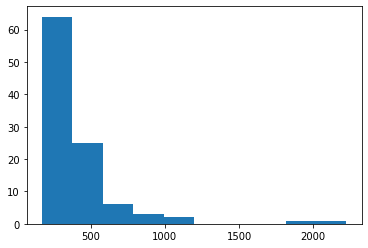

In [38]:
print("# videos in MOP Group:", len(len_MOPstroke_P3))
print("shortest video in MOP Group is of length", min(len_MOPstroke_P3))
print("longest video in MOP Group is of length", max(len_MOPstroke_P3))
plt.hist(len_MOPstroke_P3)
plt.show()

#### Read group 2

In [39]:
file_directory = dir2
file_names = glob.glob(file_directory+"/*preprocessed_crop.csv")
len_sham_P3 = []
sham_P3 = []
for num, file_name in enumerate(file_names):
    file = file_name.split("/")[-1].split("_preprocessed")[0]
    df = load_and_interpolate(file_name, fps_dict[file])
    len_sham_P3.append(len(df))
    sham_P3.append(df.values)

# videos in MOP Group: 83
shortest video in MOP Group is of length 154
longest video in MOP Group is of length 518


(array([ 9., 14., 22., 12.,  8.,  1.,  4.,  5.,  2.,  6.]),
 array([154. , 190.4, 226.8, 263.2, 299.6, 336. , 372.4, 408.8, 445.2,
        481.6, 518. ]),
 <a list of 10 Patch objects>)

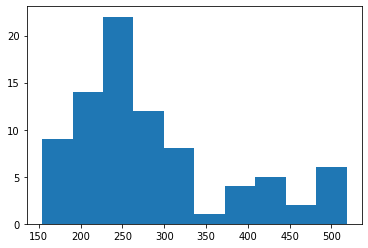

In [40]:
print("# videos in MOP Group:", len(len_sham_P3))
print("shortest video in MOP Group is of length", min(len_sham_P3))
print("longest video in MOP Group is of length", max(len_sham_P3))
plt.hist(len_sham_P3)
plt.show()

Suppose we have an array with 3 rows and 6 columns. Columns indicate x1, y1, likelihood1, x2, y2, likelihood2 (like the data structure we have). By indexing we can separate x, y and likelihood columns. Later we use this idea in MyData_Q.

a = np.array([[1,2,3,10,13,16],[4,5,6,11,14,17], [7,8,9,12,15,18]])


 - a[:,0::3] returns  x1, x2

 - a[:,1::3] returns y1, y2

 - a[:,2::3] returns likelihood1,  likelihood2


### Slice each video into episodes of length n

In [41]:
def sliced_vidoes(input_, n=episode_len, m=episode_overlap):
    #input is a list of lists
    #n: group size
    #m: overlap size
    input_sliced = []
    for k in range(len(input_)):
        input_sliced.extend([input_[k][i:i+n] for i in range(0, len(input_[k]), n-m)][:-n//(n-m)])
    return input_sliced

In [42]:
stroke_0 = sliced_vidoes(MOPstroke_P3)
print("number of episodes for MOPstroke_P3 group:", len(stroke_0))
stroke_1 = sliced_vidoes(sham_P3)
print("number of episodes for sham_P3 group:", len(stroke_1))

number of episodes for MOPstroke_P3 group: 1630
number of episodes for sham_P3 group: 805


### split the dataset into training and test sets

In [43]:
all_data = stroke_0 + stroke_1
all_labels = len(stroke_0)*[0] + len(stroke_1)*[1]

data_lst, labels = shuffle(all_data, all_labels, random_state=10)

# I pass an int to random_state such that the output is reproducible across multiple function calls
X_train, X_test, label_train, label_test = train_test_split(data_lst, labels, 
                                                    test_size=0.1, 
                                                    random_state=0
                                                    )


print('len(train_set):', len(X_train))
print('len(test_set):', len(X_test))
print("training:", sorted(Counter(label_train).items()))
print("test:", sorted(Counter(label_test).items()))
#print(X_train)

len(train_set): 2191
len(test_set): 244
training: [(0, 1459), (1, 732)]
test: [(0, 171), (1, 73)]


In [44]:
sc_x = StandardScaler()
train_concat = np.concatenate(X_train, axis=0)
test_concat = np.concatenate(X_test, axis=0)
train_scaled = sc_x.fit_transform(train_concat)
test_scaled = sc_x.transform(test_concat)
train_scaled[:, 2::3] = train_concat[:, 2::3]
test_scaled[:, 2::3] = test_concat [:, 2::3]
X_train = train_scaled.reshape(len(X_train), 100, 45)
X_test = test_scaled.reshape(len(X_test), 100, 45)

### balance the classes in each batch

If you have class imbalance, use a weighted sampler, so that you see all classes with equal probability

The weighted sampling should only be used for training, to balance the classes in each batch, which hopefully helps the training.

The validation and test accuracy is calculated on the complete datasets without any sampling (shuffle is also not needed here, since the order of the data won’t change the metrics).

In [45]:
class MyData_Q(Dataset):

    def __init__(self, train_data, train_label):
        self.train_data = train_data
        self.train_label = train_label

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, item):
        seq_len = len(self.train_data[item])
        X = self.train_data[item][:, 0::3]
        Y = self.train_data[item][:, 1::3]
        LH = self.train_data[item][:, 2::3] # likelihood
        LH_T = np.transpose(LH, (1, 0))
        
        #likelihood<0.6 -->quality index=0
        #0.6<=likelihood<0.8 -->quality index=1
        #0.8<=likelihood<=1 --> quality index=2
        
        quality_indices = 2 * np.logical_and(0.8<=LH_T, LH_T<=1.0) + 1 * np.logical_and(0.6<=LH_T, LH_T<0.8) 
        return np.transpose(X, (1, 0)), np.transpose(Y, (1, 0)), quality_indices, self.train_label[item]


In [46]:
def Sampler(w_labels):
    count = Counter(w_labels)   
    print(count)
    class_count = torch.from_numpy(np.array([count[i] for i in range(len(count))]))   
    weight = 1./class_count 
    samples_weight = np.array([weight[t] for t in w_labels])
    samples_weight=torch.from_numpy(samples_weight) # a sequence of weights, not necessary summing up to one
    #Sample elements from [0,..,len(weights)-1] with given probabilities (weights).
    sampler = torch.utils.data.WeightedRandomSampler(samples_weight, 
                                                 len(samples_weight), 
                                                 replacement=True,) 
    return sampler


train_sampler = Sampler(label_train)
train_data = MyData_Q(X_train, label_train)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

test_data = MyData_Q(X_test, label_test)
test_loader = DataLoader(test_data, batch_size=len(test_data))

Counter({0: 1459, 1: 732})


In [47]:
x, y, q, t = next(iter(train_loader))

In [48]:
class classifier_conv(nn.Module):
    def __init__(self, in_channel, n_classes, hidden_unit=128):
        super(classifier_conv, self).__init__()
        self.n_classes  = n_classes
        self.hidden_unit = hidden_unit
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channel, hidden_unit, kernel_size=10, stride=5, padding=3, bias=False),
            nn.BatchNorm1d(hidden_unit),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_unit, hidden_unit, kernel_size=8, stride=4, padding=2, bias=False),
            nn.BatchNorm1d(hidden_unit),
            nn.ReLU(inplace=True))
        self.fc = nn.Linear(hidden_unit*5, self.n_classes)
        
        def _weights_init(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.apply(_weights_init)

    def forward(self, x):
        bs = x.size(0)        
        x = self.encoder(x) #[bs, 38, 100] [bs, input_channels,  L=100]
        #print(x.size()) # [bs, 128, 5]
        x = self.fc(x.view(bs, -1)) #[bs, 128*5]
        return x

In [49]:
##
x, y, q, t = next(iter(test_loader))
#print(q[100,0,-35:])

nq = 3
onehot_quality = F.one_hot(q.view(1,-1).to(torch.int64), nq).view(q.size(0), q.size(1), q.size(2), nq)
onehot_quality = onehot_quality.permute(0, 1, 3, 2)
bs, nf, _, l = onehot_quality.size()

X_encoded = torch.mul(x.unsqueeze(2).float(), onehot_quality.float()).reshape(bs, nf*nq, l)
#print(X_encoded[100,0:3,-35:])

In [50]:
class classifier_fc(nn.Module):
    def __init__(self, in_channel, n_classes, hidden_unit=32):
        super(classifier_fc, self).__init__()
        self.n_classes  = n_classes
        self.hidden_unit = hidden_unit
        self.encoder = nn.Sequential(
            nn.Linear(in_channel, hidden_unit),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_unit, hidden_unit//2),
            nn.ReLU(inplace=True),)
        self.fc = nn.Linear(hidden_unit//2, self.n_classes)
        
        def _weights_init(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.apply(_weights_init)

    def forward(self, x):
        bs = x.size(0)    
        x = self.encoder(x.view(bs, -1)) #[bs, input_channels*L]
        x = self.fc(x.view(bs, -1)) 
        return x

In [51]:
class E2EStateClassifier(torch.nn.Module):
    def __init__(self, hidden_size, in_channel, encoding_size, output_size, cell_type='GRU', num_layers=1, dropout=0,
                 bidirectional=True, device=device):
        super(E2EStateClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.in_channel = in_channel
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.encoding_size = encoding_size
        self.bidirectional = bidirectional
        self.output_size = output_size
        self.device = device

        self.fc = torch.nn.Sequential(torch.nn.Linear(self.hidden_size*(int(self.bidirectional) + 1), self.encoding_size)).to(self.device)
        self.nn = torch.nn.Sequential(torch.nn.Linear(self.encoding_size, self.output_size)).to(self.device)
        if cell_type=='GRU':
            self.rnn = torch.nn.GRU(input_size=self.in_channel, hidden_size=self.hidden_size, num_layers=num_layers,
                                    batch_first=False, dropout=dropout, bidirectional=bidirectional).to(self.device)
        elif cell_type=='LSTM':
            self.rnn = torch.nn.LSTM(input_size=self.in_channel, hidden_size=self.hidden_size, num_layers=num_layers,
                                    batch_first=False, dropout=dropout, bidirectional=bidirectional).to(self.device)
        else:
            raise ValueError('Cell type not defined, must be one of the following {GRU, LSTM, RNN}')

    def forward(self, x):
        x = x.permute(2,0,1)
        if self.cell_type=='GRU':
            past = torch.zeros(self.num_layers * (int(self.bidirectional) + 1), x.shape[1], self.hidden_size).to(self.device)
        elif self.cell_type=='LSTM':
            h_0 = torch.zeros(self.num_layers * (int(self.bidirectional) + 1), (x.shape[1]), self.hidden_size).to(self.device)
            c_0 = torch.zeros(self.num_layers * (int(self.bidirectional) + 1), (x.shape[1]), self.hidden_size).to(self.device)
            past = (h_0, c_0)
        out, _ = self.rnn(x, past)  # out shape = [seq_len, batch_size, num_directions*hidden_size]
        encodings = self.fc(out[-1].squeeze(0))
        return self.nn(encodings)

In [52]:
#Classifier = classifier_fc((15+15)*3*100, n_classes, hidden_unit=10)
#Classifier = classifier_conv(30, n_classes, hidden_unit=128)
Classifier = E2EStateClassifier(hidden_size=128, in_channel=(15+15)*3, encoding_size=10, output_size=n_classes, device=device, cell_type = "GRU")
Classifier = Classifier.to(device)
Classifier.train() 

E2EStateClassifier(
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
  (nn): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
  )
  (rnn): GRU(90, 128, bidirectional=True)
)

### Optimizer

Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.
PyTorch applies weight decay to both weights and bias

In [53]:
optimizer = optim.Adam(Classifier.parameters(), lr=lr, weight_decay=1e-6) 

### Criterion

In [54]:
criterion = nn.CrossEntropyLoss()  

In [55]:
def onehot_encode(x, q, nq = 3):
    onehot_quality = F.one_hot(q.view(1,-1).to(torch.int64), nq).view(q.size(0), q.size(1), q.size(2), nq)
    onehot_quality = onehot_quality.permute(0, 1, 3, 2)
    bs, nf, _, l = onehot_quality.size()

    x_encoded = torch.mul(x.unsqueeze(2).float(), onehot_quality.float()).reshape(bs, nf*nq, l) 
    return x_encoded

In [56]:
def train(epoch, Classifier, train_loader, device, optimizer):
    Classifier.train()
    total_loss = 0
    total_acc = 0
    for i, (x, y, q, target) in enumerate(train_loader):
        x, y, q, target = x.to(device), y.to(device), q.to(device), target.to(device) 
        x_encoded = onehot_encode(x, q)
        y_encoded = onehot_encode(y, q)
        
        input_ = torch.cat((x_encoded, y_encoded), dim=1)
        optimizer.zero_grad()
        logit = Classifier(input_.float())
      
        loss = criterion(logit, target)
        total_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        
        pred = logit.max(1, keepdim=True)[1] # get the index of the max log-probability
        acc = 1.*pred.eq(target.view_as(pred)).sum().item()/len(x)
        total_acc+=acc
        
    total_loss = total_loss/float(len(train_loader))
    total_acc = total_acc/float(len(train_loader))
    print(f'Train epoch {epoch} ----> loss_train:{loss.item()}, accuracy_train:{acc*100}')
    return total_loss, total_acc

In [57]:
def test(epoch, Classifier, test_loader, device):
    Classifier.eval()
    with torch.no_grad():
        x, y, q, target = next(iter(test_loader))
        x, y, q, target = x.to(device), y.to(device), q.to(device), target.to(device)
        x_encoded = onehot_encode(x, q)
        y_encoded = onehot_encode(y, q)
        
        input_ = torch.cat((x_encoded, y_encoded), dim=1)

        logit = Classifier(input_.float())
        loss = criterion(logit, target)

        pred = logit.max(1, keepdim=True)[1] # get the index of the max log-probability
        acc = 1.*pred.eq(target.view_as(pred)).sum().item()/len(x)

        print(f'Test epoch {epoch} ----> loss_test:{loss.item()}, accuracy_test:{acc*100}') 
        return loss, acc    

In [58]:
if not os.path.isdir('checkpoint'):
    os.makedirs('checkpoint')

train_loss_lst = []
train_acc_lst = []
test_loss_lst = []
test_acc_lst = []
for epoch in range(epochs):
    train_loss, train_acc = train(epoch, Classifier, train_loader, device, optimizer)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    test_loss, test_acc = test(epoch, Classifier, test_loader, device)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
    
    
# torch.save(
#     {'model': Classifier.state_dict()},
#     f'checkpoint/classifier.pt',)

Train epoch 0 ----> loss_train:0.50072181224823, accuracy_train:86.66666666666667
Test epoch 0 ----> loss_test:0.5565370917320251, accuracy_test:68.44262295081968
Train epoch 1 ----> loss_train:0.5144981145858765, accuracy_train:86.66666666666667
Test epoch 1 ----> loss_test:0.4894435703754425, accuracy_test:76.22950819672131
Train epoch 2 ----> loss_train:0.638618528842926, accuracy_train:46.666666666666664
Test epoch 2 ----> loss_test:0.5202725529670715, accuracy_test:73.36065573770492
Train epoch 3 ----> loss_train:0.498960942029953, accuracy_train:80.0
Test epoch 3 ----> loss_test:0.501947283744812, accuracy_test:76.63934426229508
Train epoch 4 ----> loss_train:0.434619277715683, accuracy_train:86.66666666666667
Test epoch 4 ----> loss_test:0.4861672520637512, accuracy_test:78.27868852459017
Train epoch 5 ----> loss_train:0.5089713335037231, accuracy_train:80.0
Test epoch 5 ----> loss_test:0.43879497051239014, accuracy_test:82.37704918032787
Train epoch 6 ----> loss_train:0.5331366

<Figure size 1080x720 with 0 Axes>

(0.0, 1.0)

Text(0.5, 1.0, 'Training Loss')

(0.0, 1.0)

Text(0.5, 1.0, 'Test Loss')

(0.5, 1.0)

Text(0.5, 1.0, 'Training Accuracy')

(0.5, 1.0)

Text(0.5, 1.0, 'Test Accuracy')

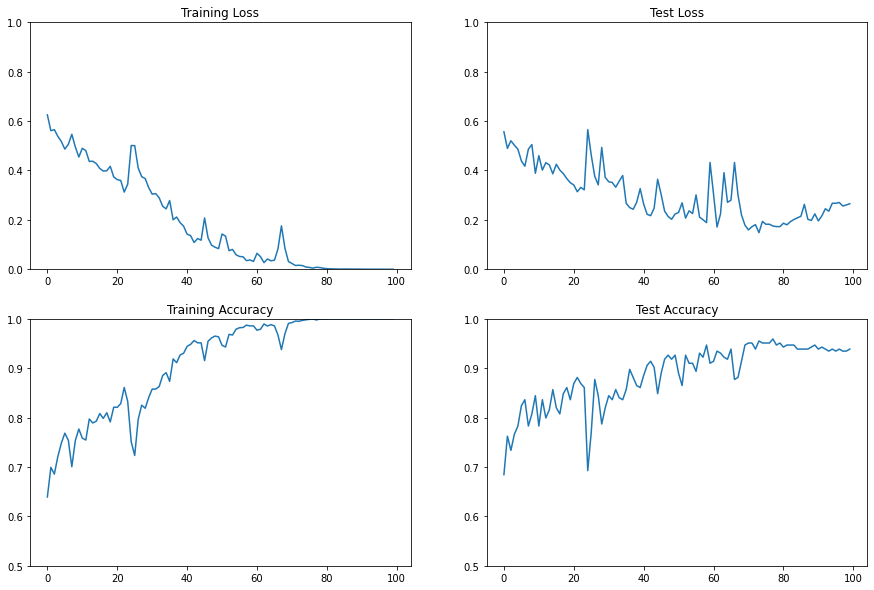

In [59]:
plt.figure(figsize=[15,10])
plt.subplot(2, 2, 1)
plt.ylim([0,1])
plt.plot(train_loss_lst)
plt.title("Training Loss")
plt.subplot(2, 2, 2)
plt.ylim([0,1])
plt.plot(test_loss_lst)
plt.title("Test Loss")
plt.subplot(2, 2, 3)
plt.ylim([0.5,1])
plt.plot(train_acc_lst)
plt.title("Training Accuracy")
plt.subplot(2, 2, 4)
plt.ylim([0.5,1])
plt.plot(test_acc_lst)
plt.title("Test Accuracy")
#plt.savefig(out_dir + str(labels_plot) + "performance_plot.pdf")
plt.show()

In [60]:
from captum.attr import IntegratedGradients

features_name = []
for col in df.columns:
    if col.split('.')[1]=='x':
        features_name.append(col)
for col in df.columns:
    if col.split('.')[1]=='y':
        features_name.append(col)

ig = IntegratedGradients(Classifier)

test_loader = DataLoader(test_data, batch_size=100)
x, y, q, target=next(iter(test_loader))
x, y, q = x.to(device), y.to(device), q.to(device)
x_encoded = onehot_encode(x, q)
y_encoded = onehot_encode(y, q)
test_input_tensor = torch.cat((x_encoded, y_encoded), dim=1).float()

nq = 3
onehot_quality = F.one_hot(q.view(1,-1), nq).view(q.size(0), q.size(1), q.size(2), nq).permute(0, 1, 3, 2)


In [61]:
importance_data = []
torch.backends.cudnn.enabled=False
test_input_tensor.requires_grad = True

for t in range(2):
    attr, delta = ig.attribute(test_input_tensor, target=t, return_convergence_delta=True)
    print(attr.shape)
    attr_x = attr[:, :45, :]
    attr_y = attr[:, 45:, :]
    print(attr_x.shape)
    attr_x = torch.reshape(attr_x, [attr_x.size(0), 15, 3, 100])
    print(attr_x.shape)
    print(attr_y.shape)
    attr_y = torch.reshape(attr_y, [attr_x.size(0), 15, 3, 100])
    print(attr_y.shape)
    output_x = (torch.mul(attr_x, onehot_quality.float()).sum(dim=2)).squeeze()
    output_y = (torch.mul(attr_y, onehot_quality.float()).sum(dim=2)).squeeze()
    print(output_x.shape)
    print(output_y.shape)
    importances = []
    importances.extend(output_x.detach().cpu().mean(axis=2).mean(axis=0).numpy())
    importances.extend(output_y.detach().cpu().mean(axis=2).mean(axis=0).numpy())
    importance_data.append(importances)

torch.Size([100, 90, 100])
torch.Size([100, 45, 100])
torch.Size([100, 15, 3, 100])
torch.Size([100, 45, 100])
torch.Size([100, 15, 3, 100])
torch.Size([100, 15, 100])
torch.Size([100, 15, 100])
torch.Size([100, 90, 100])
torch.Size([100, 45, 100])
torch.Size([100, 15, 3, 100])
torch.Size([100, 45, 100])
torch.Size([100, 15, 3, 100])
torch.Size([100, 15, 100])
torch.Size([100, 15, 100])


Text(0, 0.5, 'importance score')

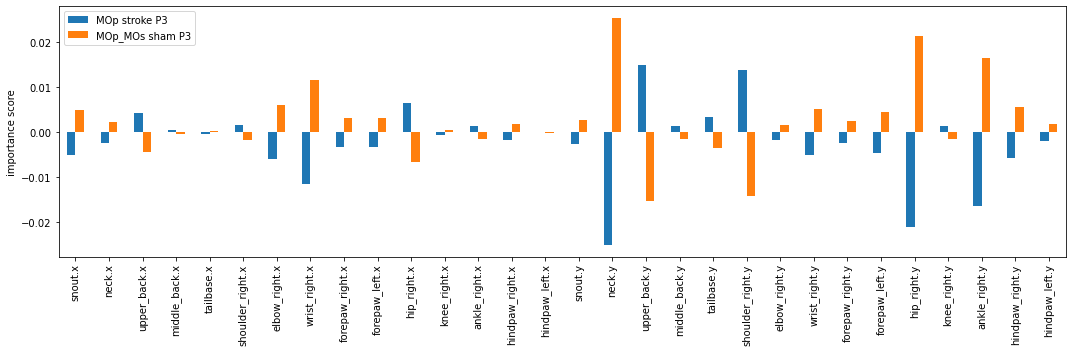

In [62]:
importance_df = pd.DataFrame(importance_data, columns = features_name).T
importance_df.columns = labels_plot
#importance_df.to_csv(out_dir + str(labels_plot) + "importance_score.csv")
importance_df.plot.bar(figsize=(15,5))
plt.legend(loc="upper left")
plt.ylabel("importance score")
plt.tight_layout()
#plt.savefig(out_dir + str(labels_plot) + "importance_plot.pdf")
plt.show()